# $\fbox{3-2}$ 健診レコードの擬似生成

## 健診とは

## 健診レコードの欠損

### 血圧情報の擬似生成

In [1]:
# グラフを移動拡大縮小したい場合
%matplotlib notebook
# グラフをインラインで表示
# %matplotlib inline

import gc
import math
import pickle

# 本書 1-3 章の関数群を含む自作ライブラリ
import mylibs.mylib1 as mylib1
import mylibs.mylib2 as mylib2
import mylibs.mylib3 as mylib3

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import norm

# 表示する行・列の数を設定
pd.options.display.max_rows = 8
pd.options.display.max_columns = 12

# matplotlib のフォントを設定
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['mathtext.fontset'] = 'stix'

In [2]:
df_bp = pd.read_csv('./public_stats/processed/df_bp.csv')

f = open('./public_stats/processed/dict_bp_min_dist.binaryfile', 'rb')  # rb: Read Binary
dict_bp_min_dist = pickle.load(f)
f.close()

f = open('./public_stats/processed/dict_sbp_max.binaryfile', 'rb')  # rb: Read Binary
dict_sbp_max = pickle.load(f)
f.close()

f = open('./public_stats/processed/dict_dbp_max.binaryfile', 'rb')  # rb: Read Binary
dict_dbp_max = pickle.load(f)
f.close()

### 健診レコードの擬似生成

In [3]:
dict_bp_min_dist['M']['dbp'].keys()

dict_keys(['20s', '30s', '40s', '50s', '60s', '70s'])

In [4]:
def alb_to_ageband(alb):
    if alb <= 29:
        return '20s'
    elif alb >= 70:
        return '70s'
    else:
        return str(int(alb // 10 * 10)) + 's'


alb_to_ageband(55)

'50s'

In [5]:
np.random.choice(dict_bp_min_dist['M']['dbp']['20s'], 100, replace=True)

array([ 80,  60,  70,  80,  70,  80,  60,  50,  70,  50,  60,  60,  80,
        60,  80,  70,  60,  60,  80,  70,  70,  60,  70,  80,  70,  60,
        70,  70,  50,  60,  80,  70,  80,  80,  80,  70,  70,  80,  80,
        60,  80,  90,  70,  80,  80,  70,  80,  60,  60,  60,  70,  80,
        80,  80,  80,  60,  50,  60,  60,  80,  70,  80,  60,  60,  60,
        70,  80,  80,  70,  70,  70,  60,  60,  60,  70,  60,  70,  80,
        80,  60,  70,  80,  80,  70,  80,  80,  80,  80,  80, 110,  70,
        70,  60,  60,  50,  60,  70,  70,  80,  70], dtype=int16)

<IPython.core.display.Javascript object>


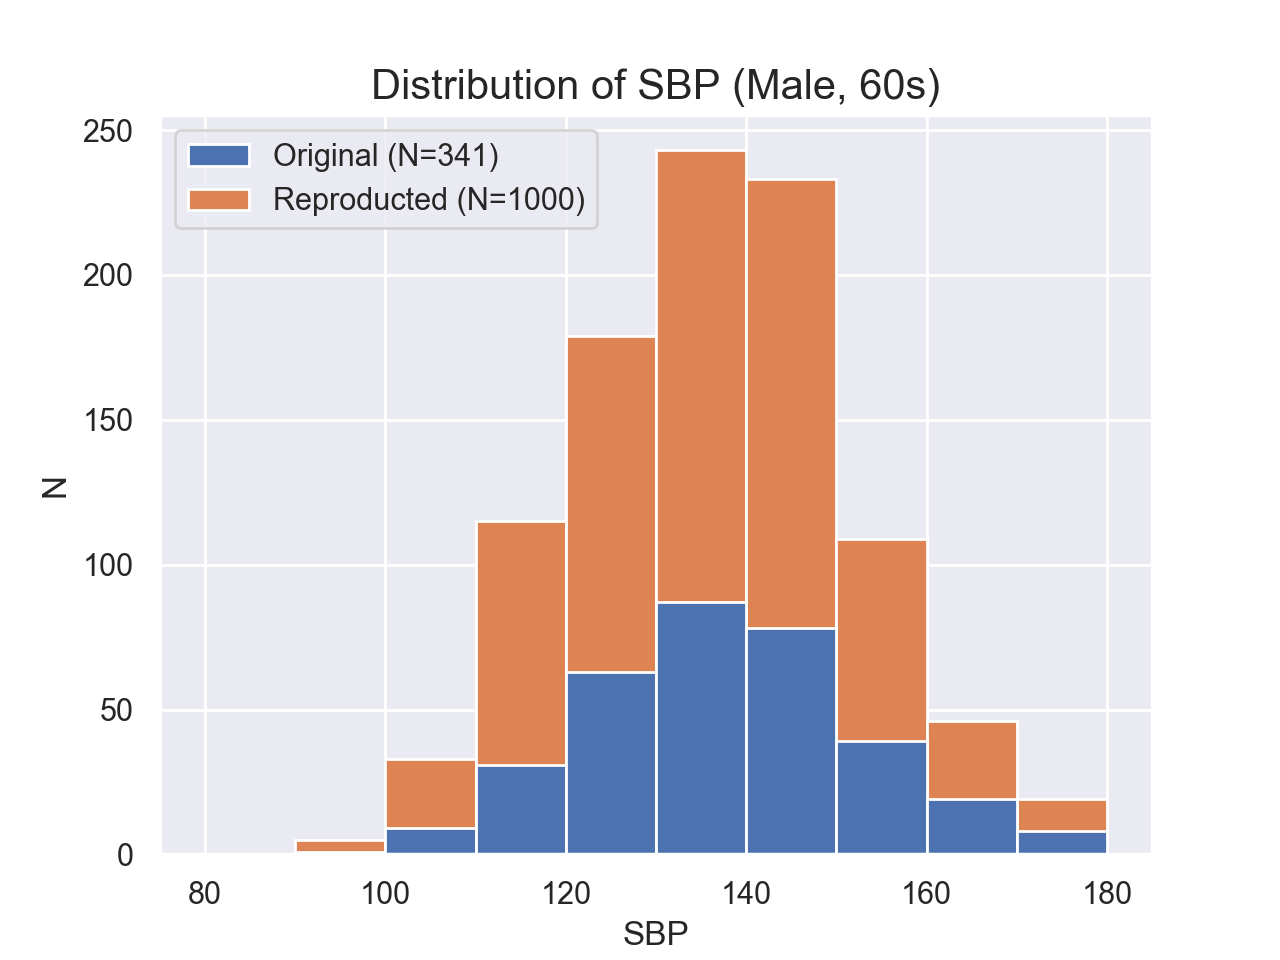

Text(0.5, 1.0, 'Distribution of SBP (Male, 60s)')

In [6]:
# np.random.choice による出力が元の分布に従っていることをヒストグラムにより確認

import seaborn as sns
sns.set()

fig = plt.figure()
ax = fig.add_subplot(111)

# Original Distribution
sbp_min_0 = dict_bp_min_dist['M']['sbp']['60s']
sbp_max_0 = [dict_sbp_max[sbp_min] for sbp_min in sbp_min_0]
sbp_0 = (sbp_min_0 + sbp_max_0 + 1) / 2  # 血圧
l = len(np.unique(sbp_0))
label = 'Original (N=' + str(len(sbp_0)) + ')'
ax.hist(sbp_0, bins=l, range=(80, 180), label=label, zorder=2)

# Reproducted Distribution
sbp_min_1 = np.random.choice(
    dict_bp_min_dist['M']['sbp']['60s'], 1000, replace=True)
sbp_max_1 = [dict_sbp_max[sbp_min] for sbp_min in sbp_min_1]
sbp_1 = (sbp_min_1 + sbp_max_1 + 1) / 2
label = 'Reproducted (N=1000)'
ax.hist(sbp_1, bins=l, range=(80, 180), label=label, zorder=1)
ax.set_xlabel('SBP')
ax.set_ylabel('N')

ax.legend(loc='best')
ax.set_title('Distribution of SBP (Male, 60s)', fontsize=15)

In [7]:
def make_random_bp_in_range(dbp_min, dbp_max, sbp_min, sbp_max, rs): 
    n = len(sbp_min)
    np.random.seed(rs)
    j = np.random.choice(np.arange(n), 1)
    rs = rs + 1
    np.random.seed(rs)
    dbp = int(np.random.rand() *
              (dbp_max[j] - dbp_min[j]) + dbp_min[j])
    rs = rs + 1
    np.random.seed(rs)
    sbp = int(np.random.rand() *
              (sbp_max[j] - sbp_min[j]) + sbp_min[j])
    rs = rs + 1
    return (dbp, sbp, rs)

In [8]:
def make_random_bp(dict_bp_min_dist, sex, alb, bp_class, rs):  # rs: Random Seed
    dbp_class_border = [40, 80,  85,  90, 100, 110, 160]
    sbp_class_border = [70, 120, 130, 140, 160, 180, 200]
    if not(-1 <= bp_class <= 5):
        return None
    else:
        ageband = alb_to_ageband(alb)
        dbp_min = dict_bp_min_dist[sex]['dbp'][ageband]
        dbp_max = np.array([dict_dbp_max[dbpm] for dbpm in dbp_min])
        sbp_min = dict_bp_min_dist[sex]['sbp'][ageband]
        sbp_max = np.array([dict_sbp_max[sbpm] for sbpm in sbp_min])
        if bp_class == -1:
            # 血圧分類属性を指定せず血圧ランダム生成
            (dbp, sbp, rs) = make_random_bp_in_range(dbp_min, dbp_max, sbp_min, sbp_max, rs)
            return (dbp, sbp)
        else:
            # 血圧分類属性を指定して血圧ランダム生成
            satisfy_dbp = (dbp_class_border[bp_class] <= dbp_min) & (
                        dbp_min < dbp_class_border[bp_class + 1])
            satisfy_sbp = (sbp_class_border[bp_class] <= sbp_min) & (
                        sbp_min < sbp_class_border[bp_class + 1])
            dbp_min = np.append(dbp_min[satisfy_dbp], dbp_min[satisfy_sbp])
            dbp_max = np.append(dbp_max[satisfy_dbp], dbp_max[satisfy_sbp])
            sbp_min = np.append(sbp_min[satisfy_dbp], sbp_min[satisfy_sbp])
            sbp_max = np.append(sbp_max[satisfy_dbp], sbp_max[satisfy_sbp])
            # 血圧をランダム生成
            try:
                (dbp, sbp, rs) = make_random_bp_in_range(dbp_min, dbp_max, sbp_min, sbp_max, rs)
            except:
                dbp = int((dbp_class_border[bp_class] + dbp_class_border[bp_class + 1]) / 2)
                sbp = int((sbp_class_border[bp_class] + sbp_class_border[bp_class + 1]) / 2)
            return (dbp, sbp)


(sex, alb, bp_class, rs) = ('M', 55, -1, 100)
print(make_random_bp(dict_bp_min_dist, sex, alb, bp_class, rs))

(sex, alb, bp_class, rs) = ('M', 20, 5, 100)
print(make_random_bp(dict_bp_min_dist, sex, alb, bp_class, rs))

(sex, alb, bp_class, rs) = ('M', 20, 6, 100)
print(make_random_bp(dict_bp_min_dist, sex, alb, bp_class, rs))

(74, 115)
(114, 155)
None


In [9]:
def make_new_df_hc(df_info, i, hct, rs):
    (iid, sex, birth_ym, bp_class) = df_info.loc[i, [
        'iid', 'sex', 'birth_ym', 'bp_class']].values
    birth_t = mylib1.ym_to_t(birth_ym)
    alb = int(hct - birth_t)
    (dbp, sbp) = make_random_bp(dict_bp_min_dist, sex, alb, bp_class, rs)
    hc_ym = mylib1.t_to_ym(hct)
    # １行データは１列データに変換されてしまうため転置
    df_hc = pd.DataFrame([iid, hc_ym, dbp, sbp]).T
    df_hc.columns = ['iid', 'hc_ym', 'dbp', 'sbp']
    return df_hc


df_info = pd.read_csv('./pseudo_medical/records/excl_bp/info.csv')
df_info['bp_class'] = -1  # 初期値設定
(i, hct, rs) = (0, 2010.55, 100)
df_hc = make_new_df_hc(df_info, i, hct, rs)

df_hc

,iid,hc_ym,dbp,sbp
0,i000000,2010/07,74,115


In [10]:
rs = 0  # 初期値設定
df_hcs = None  # # DataFrame of Health CheckupS

for i in df_info.index:
    st = mylib1.ym_to_t(df_info.loc[i, 'start_obs_ym'])
    et = mylib1.ym_to_t(df_info.loc[i, 'end_obs_ym'])
    # 血圧分類属性の決定
    rs = rs + 1
    df_hc = make_new_df_hc(df_info, i, st, rs)
    (dbp, sbp) = df_hc[['dbp', 'sbp']].values[0]
    bp_class = mylib3.calc_bp_class(dbp, sbp)
    df_info.loc[i, 'bp_class'] = bp_class

    # 健診レコードの擬似生成
    df_hcs_for_i = None
    rs = rs + 1
    np.random.seed(rs)
    if np.random.rand() > 0.5:  # 被保険者の半分が健診レコードを持つこととする
        rs = rs + 1
        pass
    else:
        # 健診レコードを観察開始から6か月後に、以後1年ごとに登場させる。
        if st + 0.5 > et:
            pass
        else:  # 健診レコード作成
            hct = st + 0.5  # 初期値
            make_record = True
            while make_record:
                rs = rs + 1
                # print(i, hct, rs)
                df_hc = make_new_df_hc(df_info, i, hct, rs)
                df_hcs_for_i = pd.concat([df_hcs_for_i, df_hc], axis=0)
                if hct + 1 > et:
                    make_record = False
                else:
                    hct = hct + 1
            df_hcs = pd.concat([df_hcs, df_hcs_for_i], axis=0)

In [11]:
print(df_info.shape)
df_info.head()

(4815, 8)


,iid,sex,family,birth_ym,start_obs_ym,end_obs_ym,death,bp_class
0,i000000,M,1,1952/06,2010/01,2013/09,0,1
1,i000001,F,2,1972/11,2010/01,2019/12,0,0
2,i000002,M,1,1978/03,2010/01,2016/09,0,0
3,i000003,M,2,1989/03,2010/01,2013/12,0,0
4,i000006,M,1,1973/11,2010/04,2013/09,0,0


In [12]:
print(df_hcs.shape)
# 健診レコードを保有する被保険者の人数を確認
print(len(df_hcs['iid'].unique()))
df_hcs.head()

(12632, 4)
2241


,iid,hc_ym,dbp,sbp
0,i000000,2010/07,88,131
0,i000000,2011/07,81,138
0,i000000,2012/07,88,140
0,i000000,2013/07,70,127
0,i000002,2010/07,76,114


In [13]:
df_info.to_csv('./pseudo_medical/records/incl_bp/info.csv', index=False)
df_hcs.to_csv('./pseudo_medical/records/incl_bp/healthckeckup.csv', index=False)

## まとめ